In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall -y dgl torch torchvision torchaudio
!pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0+cu121 \
  --index-url https://download.pytorch.org/whl/cu121
!pip install dgl==2.4.0+cu121 -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
!pip install --force-reinstall numpy==1.26.4
!pip install lime matplotlib scikit-learn

Found existing installation: dgl 2.4.0+cu121
Uninstalling dgl-2.4.0+cu121:
  Successfully uninstalled dgl-2.4.0+cu121
Found existing installation: torch 2.1.0+cu121
Uninstalling torch-2.1.0+cu121:
  Successfully uninstalled torch-2.1.0+cu121
Found existing installation: torchvision 0.16.0+cu121
Uninstalling torchvision-0.16.0+cu121:
  Successfully uninstalled torchvision-0.16.0+cu121
Found existing installation: torchaudio 2.1.0+cu121
Uninstalling torchaudio-2.1.0+cu121:
  Successfully uninstalled torchaudio-2.1.0+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 58.2 MB/s  0:00:23
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.3 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [torch]
Looking in links: https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.2/483.2 MB

# Acknowledgment:
# We express our sincere gratitude to the developers and contributors of the
# DGL library, particularly the example implementation of APPNP available at:
# https://github.com/dmlc/dgl/blob/master/examples/sparse/appnp.py
# This work served as a foundational reference and inspiration for our implementation.


In [ ]:
import dgl
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import torch.nn as nn
import torch.nn.functional as nnFn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load CN features
#cn_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_CN_dataset/Processed_histogram_features_CN/Histogram_feature_CN_FA_20bin.npy"
cn_fa_feature_path = "/home/snu/Downloads/Histogram_feature_CN_FA_20bin.npy"
ad_fa_feature_path = "/home/snu/Downloads/Histogram_feature_AD_FA_20bin.npy"
cn_features_dict = np.load(cn_fa_feature_path, allow_pickle=True).item()
cn_features = np.array(list(cn_features_dict.values()))

# Load AD features
#ad_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_AD_dataset/Processed_histogram_features_AD/Histogram_feature_AD_FA_20bin.npy"
ad_features_dict = np.load(ad_fa_feature_path, allow_pickle=True).item()
ad_features = np.array(list(ad_features_dict.values()))
cn_labels = np.zeros(cn_features.shape[0])
ad_labels = np.ones(ad_features.shape[0])

In [ ]:
X = np.vstack((cn_features, ad_features))
y = np.hstack((cn_labels, ad_labels))

scaler = StandardScaler()
X = scaler.fit_transform(X)
num_nodes = X.shape[0]
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [ ]:
alpha = 0.1 # threshold
X_norm = F.normalize(X_tensor, p=2, dim=1)
sim_matrix = torch.mm(X_norm, X_norm.T)

src, dst = torch.where(sim_matrix > alpha)
mask = src != dst
src = src[mask]
dst = dst[mask]

graph = dgl.graph((src.cpu(), dst.cpu()), num_nodes=num_nodes, device='cpu')
graph = dgl.to_bidirected(graph)
graph = dgl.add_self_loop(graph)

graph = graph.to(device)
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

print(f"Graph Nodes: {graph.num_nodes()}, Edges: {graph.num_edges()}, Device: {device}")

Graph Nodes: 221, Edges: 8625, Device: cuda


In [ ]:
class APPNP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=512, dropout=0.2, num_hops=10, alpha=0.2):
        super().__init__()
        self.f_theta = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, out_size),
        )
        self.num_hops = num_hops
        self.A_dropout = nn.Dropout(dropout)
        self.alpha = alpha
        self.loss = self.cut_loss if cut else self.modularity_loss

    def forward(self, A_hat, X):
        Z_0 = Z = self.f_theta(X)
        for _ in range(self.num_hops):
            A_drop = dglsp.val_like(A_hat, self.A_dropout(A_hat.val))
            Z = (1 - self.alpha) * (A_drop @ Z) + self.alpha * Z_0
        return Z

    def modularity_loss(self, A, S):
        C = nnFn.softmax(S, dim=1)
        d = torch.sum(A, dim=1)
        m = torch.sum(A)
        B = A - torch.ger(d, d) / (2 * m)
        return (-1 / (2 * m)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))

    def cut_loss(self, A, S):
        S = nnFn.softmax(S, dim=1)
        A_pool = torch.matmul(torch.matmul(A, S).t(), S)
        num = torch.trace(A_pool)
        D = torch.diag(torch.sum(A, dim=-1))
        D_pooled = torch.matmul(torch.matmul(D, S).t(), S)
        den = torch.trace(D_pooled)
        return -(num / den)

In [ ]:
indices = torch.stack(graph.edges())
N = graph.num_nodes()
A = dglsp.spmatrix(indices, shape=(N, N))
I = dglsp.identity(A.shape, device=device)
A_hat = A + I
D_hat = dglsp.diag(A_hat.sum(dim=1)) ** -0.5
A_hat = D_hat @ A_hat @ D_hat

In [ ]:
num_epochs = 5000
lambda_unsup = 0.09
cut = 0

In [ ]:
A_dense = A_hat.to_dense()

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)

accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []
all_fpr, all_tpr, all_y_true, all_y_proba = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
    test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

    model = APPNP(in_size=X.shape[1], out_size=2, hidden_size=512, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    ce_loss = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(A_hat, X_tensor)

        sup_loss = ce_loss(out[train_mask], y_tensor[train_mask])
        unsup_loss = model.cut_loss(A_dense, out) if cut else model.modularity_loss(A_dense, out)
        total_loss = sup_loss + lambda_unsup * unsup_loss

        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"NaN or Inf loss detected at epoch {epoch}, stopping training.")
            break

        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Sup: {sup_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Total: {total_loss.item():.4f}")


    model.eval()
    with torch.no_grad():
        logits = model(A_hat, X_tensor)
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()

    y_true_test = y_tensor[test_mask].cpu().numpy()
    y_pred_test = y_pred[test_mask.cpu().numpy()]
    y_proba_test = y_pred_proba[test_mask.cpu().numpy()][:, 1]

    acc = accuracy_score(y_true_test, y_pred_test)
    prec = precision_score(y_true_test, y_pred_test)
    rec = recall_score(y_true_test, y_pred_test)
    f1 = f1_score(y_true_test, y_pred_test)
    loss_val = log_loss(y_true_test, y_pred_proba[test_mask.cpu().numpy()])

    fpr, tpr, _ = roc_curve(y_true_test, y_proba_test)
    auc_val = auc(fpr, tpr)


    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    losses.append(loss_val)
    all_auc.append(auc_val)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_y_true.extend(y_true_test)
    all_y_proba.extend(y_proba_test)

    print(f"Fold {fold+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | Loss: {loss_val:.4f} | AUC: {auc_val:.4f}")

print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")



Training fold 1
Epoch 0 | Sup: 0.7288 | Unsup: -0.1253 | Total: 0.7175
Epoch 500 | Sup: 0.0202 | Unsup: -0.2199 | Total: 0.0005
Epoch 1000 | Sup: 0.0050 | Unsup: -0.2296 | Total: -0.0156
Epoch 1500 | Sup: 0.0032 | Unsup: -0.2324 | Total: -0.0178
Epoch 2000 | Sup: 0.0019 | Unsup: -0.2343 | Total: -0.0192
Epoch 2500 | Sup: 0.0013 | Unsup: -0.2373 | Total: -0.0201
Epoch 3000 | Sup: 0.0019 | Unsup: -0.2375 | Total: -0.0195
Epoch 3500 | Sup: 0.0016 | Unsup: -0.2411 | Total: -0.0201
Epoch 4000 | Sup: 0.0014 | Unsup: -0.2419 | Total: -0.0204
Epoch 4500 | Sup: 0.0013 | Unsup: -0.2418 | Total: -0.0204
Fold 1 | Acc: 0.7236 | Prec: 0.6364 | Rec: 0.7089 | F1: 0.6707 | Loss: 1.2316 | AUC: 0.7841

Training fold 2
Epoch 0 | Sup: 0.6931 | Unsup: -0.1250 | Total: 0.6818
Epoch 500 | Sup: 0.0278 | Unsup: -0.1967 | Total: 0.0101
Epoch 1000 | Sup: 0.0075 | Unsup: -0.2148 | Total: -0.0118
Epoch 1500 | Sup: 0.0036 | Unsup: -0.2257 | Total: -0.0167
Epoch 2000 | Sup: 0.0052 | Unsup: -0.2291 | Total: -0.0155
E

0.7276 ± 0.0304   lambda = 1

0.7302, lambda =0.5

0.7327 ± 0.0330  lambda = 0.09

0.7314 ± 0.0320 lambda = 0.1

0.7322 ± 0.0309 lambda = 0.2

0.7302 ± 0.0293 lambda = 0.05

lambda = 0.09

Average Results across 20 folds:
Accuracy: 0.7095 ± 0.0502
Precision: 0.7626 ± 0.1074
Recall: 0.4506 ± 0.2192
F1 Score: 0.5116 ± 0.2109
Cross-Entropy Loss: 1.0943 ± 0.2911
Average AUC: 0.7669 ± 0.0516

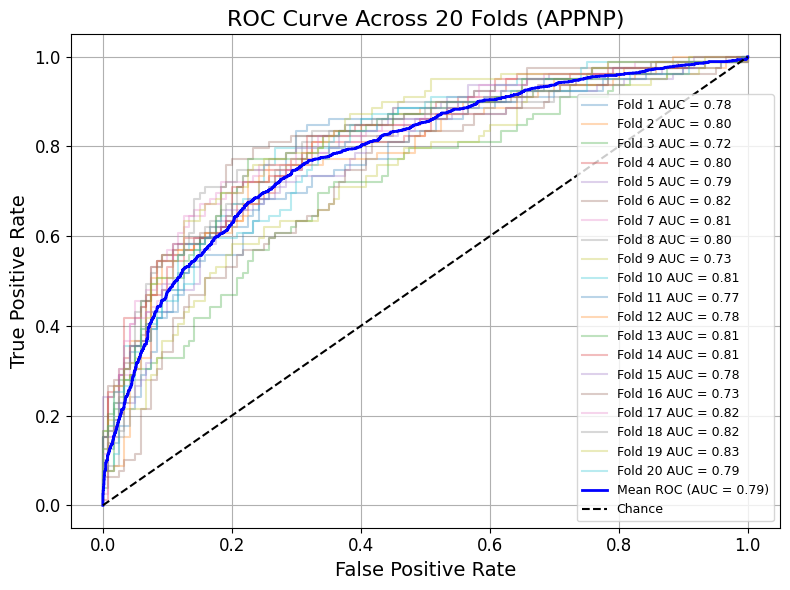

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (APPNP)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

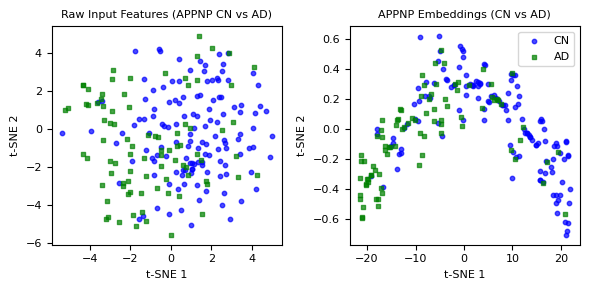

In [ ]:
X_input = X_tensor.cpu().numpy()
tsne_input = TSNE(n_components=2, init='pca', random_state=42)
input_2d = tsne_input.fit_transform(X_input)

model.eval()
with torch.no_grad():
    embeddings = model(A_hat, X_tensor).cpu().numpy()

tsne_embed = TSNE(n_components=2, init='pca', random_state=42)
embed_2d = tsne_embed.fit_transform(embeddings)

labels = y_tensor.cpu().numpy()

colors = ['blue', 'green']
markers = ['o', 's']
class_names = ['CN', 'AD']
font_size = 8

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

for cls, color, marker in zip([0, 1], colors, markers):
    idx = labels == cls
    axes[0].scatter(input_2d[idx, 0], input_2d[idx, 1],
                    c=color, marker=marker, label=class_names[cls], alpha=0.7, s=10)
axes[0].set_title("Raw Input Features (APPNP CN vs AD)", fontsize=font_size)
axes[0].set_xlabel("t-SNE 1", fontsize=font_size)
axes[0].set_ylabel("t-SNE 2", fontsize=font_size)
axes[0].tick_params(labelsize=font_size)

for cls, color, marker in zip([0, 1], colors, markers):
    idx = labels == cls
    axes[1].scatter(embed_2d[idx, 0], embed_2d[idx, 1],
                    c=color, marker=marker, label=class_names[cls], alpha=0.7, s=10)
axes[1].set_title("APPNP Embeddings (CN vs AD)", fontsize=font_size)
axes[1].set_xlabel("t-SNE 1", fontsize=font_size)
axes[1].set_ylabel("t-SNE 2", fontsize=font_size)
axes[1].tick_params(labelsize=font_size)

axes[1].legend(fontsize=font_size, loc='best')

plt.tight_layout()
plt.savefig("tsne_comparison.png", dpi=300, bbox_inches='tight')
plt.show()